In [12]:
# Download IMDb datasets (compressed TSV files)
!wget https://datasets.imdbws.com/title.basics.tsv.gz
!wget https://datasets.imdbws.com/title.ratings.tsv.gz


--2025-05-20 18:30:35--  https://datasets.imdbws.com/title.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.227.74.94, 13.227.74.67, 13.227.74.61, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.227.74.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206120095 (197M) [binary/octet-stream]
Saving to: ‘title.basics.tsv.gz’

title.basics.tsv.gz 100%[===================>] 196.57M  63.9MB/s    in 3.2s    

2025-05-20 18:30:38 (62.1 MB/s) - ‘title.basics.tsv.gz’ saved [206120095/206120095]

--2025-05-20 18:30:38--  https://datasets.imdbws.com/title.ratings.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.227.74.94, 13.227.74.67, 13.227.74.61, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.227.74.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7899725 (7.5M) [binary/octet-stream]
Saving to: ‘title.ratings.tsv.gz’

title.ratings.tsv.g 100%[===================>]   7.53M

In [13]:
import pandas as pd

# Load IMDb basics and ratings datasets
basics = pd.read_csv('title.basics.tsv.gz', sep='\t', compression='gzip', low_memory=False)
ratings = pd.read_csv('title.ratings.tsv.gz', sep='\t', compression='gzip')

# Filter for movies and TV series only
basics = basics[basics['titleType'].isin(['movie', 'tvSeries'])]

# Merge basics and ratings on 'tconst'
imdb_df = pd.merge(basics, ratings, on='tconst', how='left')

# Select and rename relevant columns
imdb_df = imdb_df.rename(columns={
    'primaryTitle': 'title',
    'startYear': 'release_year',
    'runtimeMinutes': 'runtime',
    'genres': 'genre',
    'averageRating': 'rating',
    'numVotes': 'num_votes'
})

# Keep only necessary columns
imdb_df = imdb_df[['title', 'release_year', 'runtime', 'genre', 'rating', 'num_votes']]

# Convert release_year and runtime to numeric, handle missing values
imdb_df['release_year'] = pd.to_numeric(imdb_df['release_year'], errors='coerce')
imdb_df['runtime'] = pd.to_numeric(imdb_df['runtime'], errors='coerce')

# Drop rows without titles or ratings
imdb_df = imdb_df.dropna(subset=['title', 'rating'])

# Preview cleaned IMDb data
print(imdb_df.head())


                           title  release_year  runtime  \
0                     Miss Jerry        1894.0     45.0   
1  The Corbett-Fitzsimmons Fight        1897.0    100.0   
2                       Bohemios        1905.0    100.0   
3    The Story of the Kelly Gang        1906.0     70.0   
4               The Prodigal Son        1907.0     90.0   

                        genre  rating  num_votes  
0                     Romance     5.4      224.0  
1      Documentary,News,Sport     5.3      558.0  
2                          \N     3.8       21.0  
3  Action,Adventure,Biography     6.0      989.0  
4                       Drama     5.6       31.0  


In [14]:
netflix_df = pd.read_csv('/content/netflix_titles.csv')

print(netflix_df.head())
print(netflix_df.columns)


  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

In [15]:
# Standardize column names if necessary
netflix_df.columns = netflix_df.columns.str.lower().str.strip()

# Lowercase and strip titles for consistent merging
netflix_df['title'] = netflix_df['title'].str.lower().str.strip()

# Inspect for missing values
print(netflix_df.isnull().sum())

# Example: fill missing 'release_year' with mode or drop
netflix_df['release_year'] = pd.to_numeric(netflix_df['release_year'], errors='coerce')
netflix_df['release_year'].fillna(netflix_df['release_year'].mode()[0], inplace=True)


show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


<ipython-input-15-84b4904af227>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  netflix_df['release_year'].fillna(netflix_df['release_year'].mode()[0], inplace=True)


In [16]:
imdb_df['title'] = imdb_df['title'].str.lower().str.strip()


In [17]:
combined_df = pd.merge(netflix_df, imdb_df, how='inner', on=['title', 'release_year'])

print(f"Number of matched titles: {combined_df.shape[0]}")
combined_df.head()


Number of matched titles: 5384


show_id     type                             title  \
0      s1    Movie              dick johnson is dead   
1      s3  TV Show                         ganglands   
2      s4  TV Show             jailbirds new orleans   
3      s7    Movie  my little pony: a new generation   
4      s8    Movie                           sankofa   

                        director  \
0                Kirsten Johnson   
1                Julien Leclercq   
2                            NaN   
3  Robert Cullen, José Luis Ucha   
4                   Haile Gerima   

                                                cast  \
0                                                NaN   
1  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...   
2                                                NaN   
3  Vanessa Hudgens, Kimiko Glenn, James Marsden, ...   
4  Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...   

                                             country          date_added  \
0                                      United States  September 25, 2021   
1                                                NaN  September 24, 2021   
2                                                NaN  September 24, 2021   
3                                                NaN  September 24, 2021   
4  United States, Ghana, Burkina Faso, United Kin...  September 24, 2021   

   release_year rating_x  duration  \
0          2020    PG-13    90 min   
1          2021    TV-MA  1 Season   
2          2021    TV-MA  1 Season   
3          2021       PG    91 min   
4          1993    TV-MA   125 min   

                                           listed_in  \
0                                      Documentaries   
1  Crime TV Shows, International TV Shows, TV Act...   
2                             Docuseries, Reality TV   
3                           Children & Family Movies   
4   Dramas, Independent Movies, International Movies   

                                         description  runtime  \
0  As her father nears the end of his life, filmm...     89.0   
1  To protect his family from a powerful drug lor...     44.0   
2  Feuds, flirtations and toilet talk go down amo...      NaN   
3  Equestria's divided. But a bright-eyed hero be...     90.0   
4  On a photo shoot in Ghana, an American model s...    125.0   

                         genre  rating_y  num_votes  
0  Biography,Documentary,Drama       7.4     7467.0  
1           Action,Crime,Drama       7.2     4811.0  
2       Documentary,Reality-TV       6.5      327.0  
3   Adventure,Animation,Comedy       6.8     4843.0  
4                        Drama       7.0      872.0

In [20]:
print(combined_df.columns.tolist())


['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating_x', 'duration', 'listed_in', 'description', 'runtime', 'genre', 'rating_y', 'num_votes']


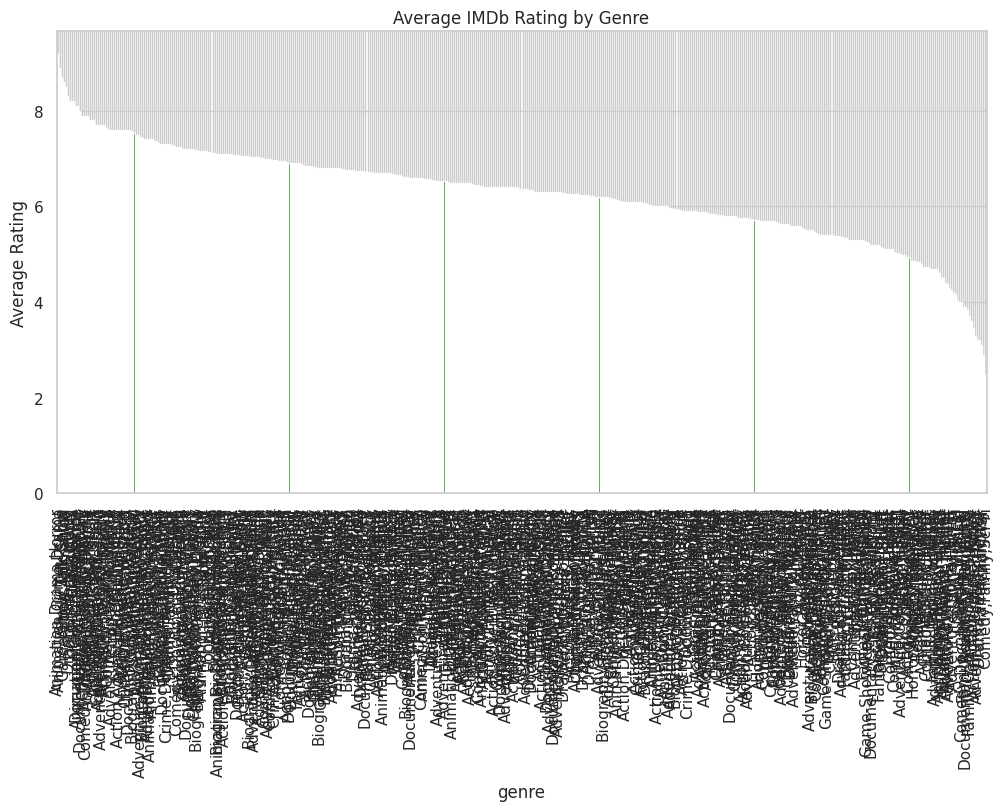

In [21]:
import matplotlib.pyplot as plt

# Average IMDb rating by genre
avg_rating = combined_df.groupby('genre')['rating_y'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
avg_rating.plot(kind='bar', color='green')
plt.title('Average IMDb Rating by Genre')
plt.ylabel('Average Rating')
plt.show()


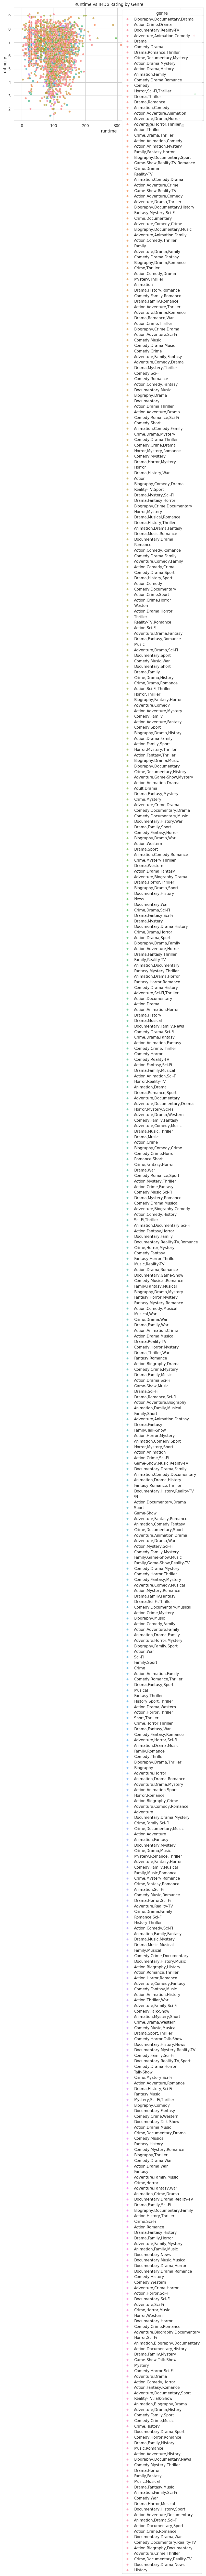

In [22]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(data=combined_df, x='runtime', y='rating_y', hue='genre', alpha=0.7)
plt.title('Runtime vs IMDb Rating by Genre')
plt.show()


In [23]:
# Sort by IMDb rating (rating_y) and show top 10
top_rated = combined_df.sort_values(by='rating_y', ascending=False)

# Optional: Filter out titles with very few votes (<1000) to avoid skewed data
top_rated_filtered = top_rated[top_rated['num_votes'] > 1000].head(10)

# Display the top-rated titles
top_rated_filtered[['title', 'rating_y', 'genre', 'runtime', 'num_votes']]


title  rating_y  \
2336                                     our planet       9.2   
464                                 attack on titan       9.1   
5108  the lord of the rings: the return of the king       9.0   
4789                               schindler's list       9.0   
1446                                      my mister       9.0   
1844                                     reply 1988       9.0   
4416                                     mahabharat       9.0   
5366                                yeh meri family       8.9   
5379                             zindagi gulzar hai       8.9   
4675                                   pulp fiction       8.9   

                           genre  runtime  num_votes  
2336                 Documentary     50.0    56790.0  
464   Action,Adventure,Animation     24.0   611005.0  
5108     Adventure,Drama,Fantasy    201.0  2078568.0  
4789     Biography,Drama,History    195.0  1523092.0  
1446                Drama,Family     70.0    12777.0  
1844         Comedy,Drama,Family     90.0    15830.0  
4416           Drama,History,War     20.0    12930.0  
5366         Comedy,Drama,Family     30.0    27109.0  
5379                     Romance     42.0     4721.0  
4675                 Crime,Drama    154.0  2335588.0

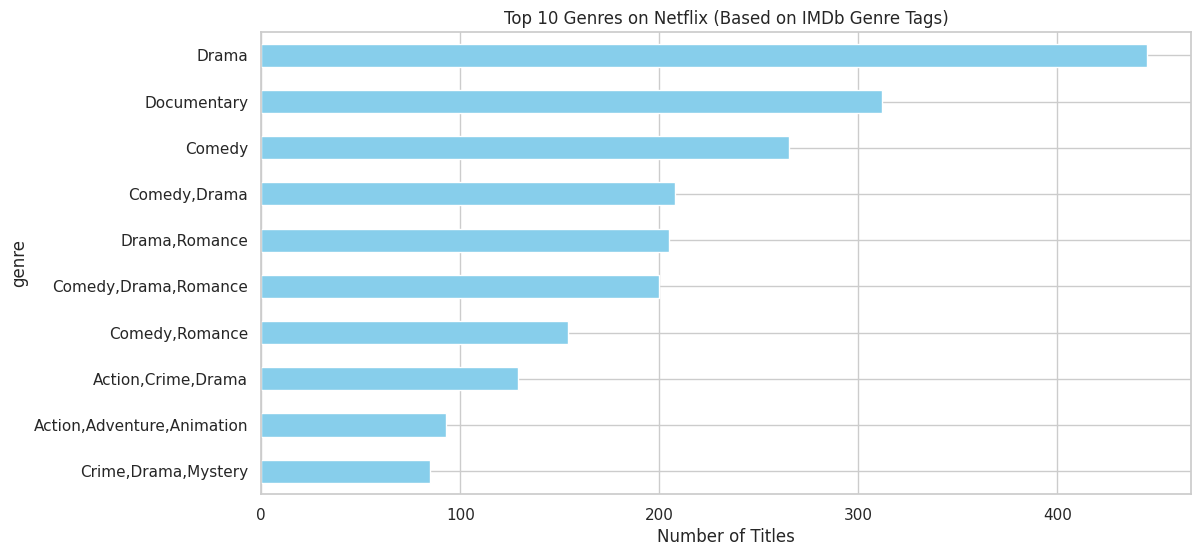

In [24]:
plt.figure(figsize=(12,6))
combined_df['genre'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Genres on Netflix (Based on IMDb Genre Tags)')
plt.xlabel('Number of Titles')
plt.gca().invert_yaxis()
plt.show()


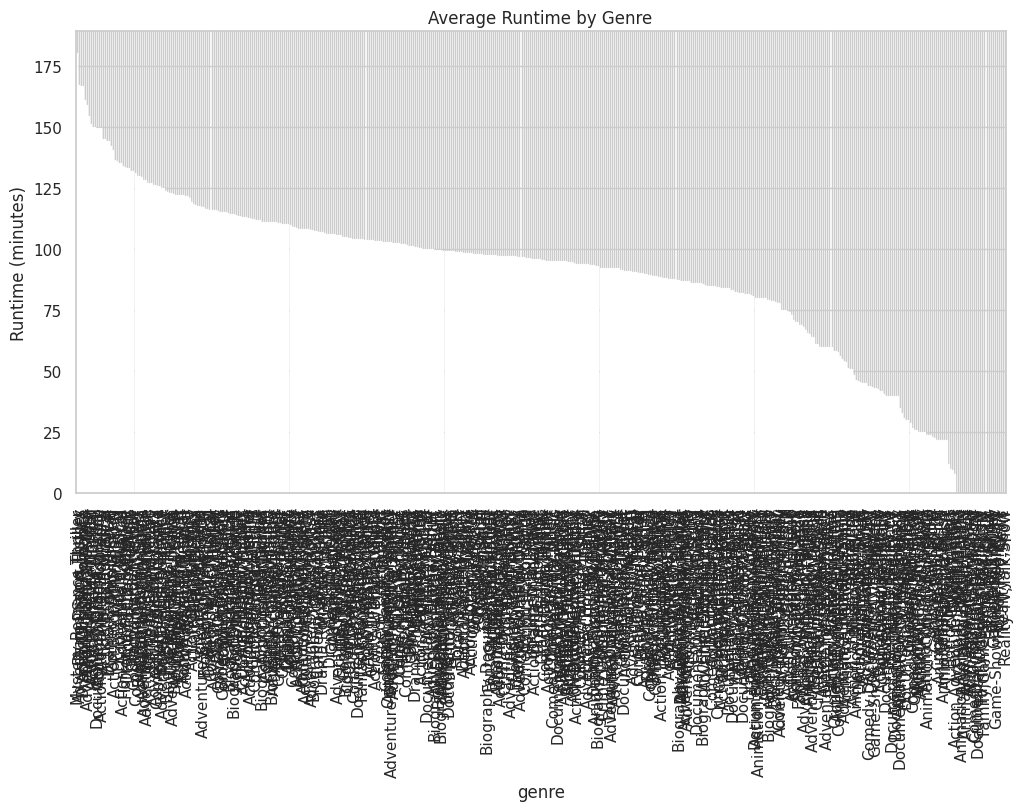

In [25]:
avg_runtime = combined_df.groupby('genre')['runtime'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
avg_runtime.plot(kind='bar', color='coral')
plt.title('Average Runtime by Genre')
plt.ylabel('Runtime (minutes)')
plt.show()


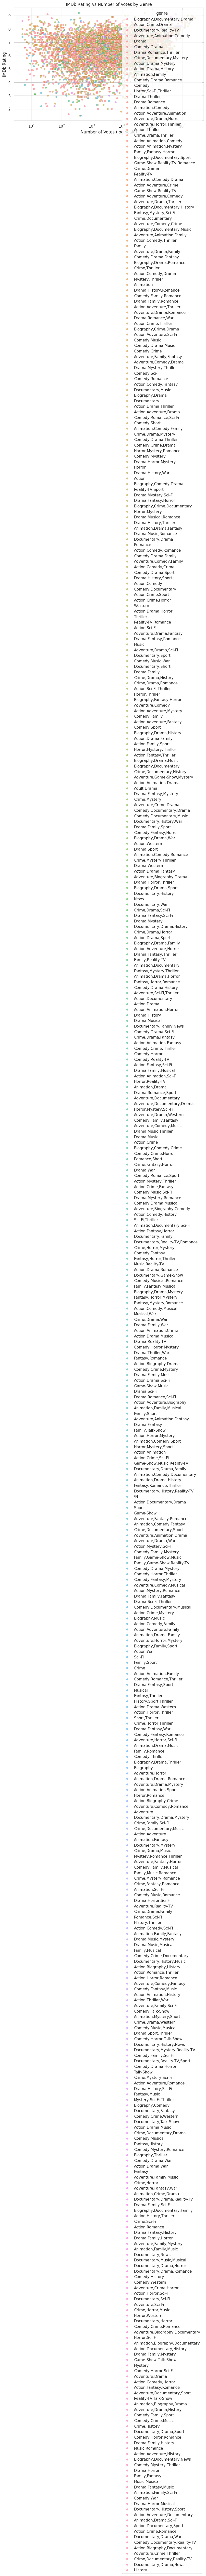

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=combined_df, x='num_votes', y='rating_y', hue='genre', alpha=0.6)
plt.xscale('log')  # Log scale to handle large vote count range
plt.title('IMDb Rating vs Number of Votes by Genre')
plt.xlabel('Number of Votes (log scale)')
plt.ylabel('IMDb Rating')
plt.show()


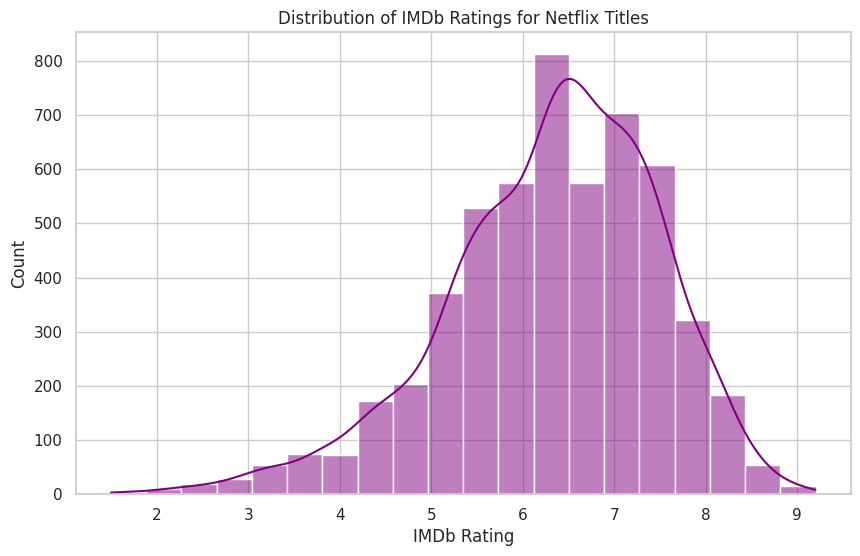

In [27]:
plt.figure(figsize=(10,6))
sns.histplot(combined_df['rating_y'], bins=20, kde=True, color='purple')
plt.title('Distribution of IMDb Ratings for Netflix Titles')
plt.xlabel('IMDb Rating')
plt.ylabel('Count')
plt.show()


In [28]:
# Save final dataset to a CSV
combined_df.to_csv('netflix_show_insights.csv', index=False)


In [29]:
from google.colab import files
files.download('netflix_show_insights.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Netflix Show Insights — Data Analytics Project
Goal: Uncover viewer preferences by combining IMDb and Netflix data.

Steps Taken:

Loaded official IMDb datasets (title.basics.tsv, title.ratings.tsv) directly into Colab.

Cleaned both IMDb and Netflix data, resolving inconsistent formats and missing values.

Merged datasets on title and release_year to enhance Netflix titles with IMDb ratings, genres, and runtimes.

Analyzed trends including genre popularity, runtime distributions, rating correlations, and top-rated titles.

Key Insights:

Documentaries and dramas are among the most common genres.

Higher IMDb ratings are generally correlated with higher vote counts.

Average runtime varies significantly across genres, with action titles tending to be longer.

Top-rated shows (with >1000 votes) are spread across multiple genres, indicating diverse audience tastes.

